In [25]:
import h5py
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import os

In [26]:
dataset_path = "/Volumes/SSD/mark/Documents/Works/MT_Dataset/mt_filtered_20250714.h5"

if "ds" in vars():
    ds.close()   # type: ignore

ds = h5py.File(dataset_path, "r")
for attr in ds.attrs:
    print(f"{attr}: {ds.attrs[attr]}")

author: Mark Vodyanitskiy (mvodya@icloud.com)
created_at: 2025-07-13T14:26:08.378871
filter_rules: MIN_TOTAL_POINTS=50, MIN_MOVING_POINTS=5, MIN_MAX_SPEED=20, SPEED_MOVING_MIN=10, SPEED_SANITY_MAX=800
filtered_at: 2026-01-08T06:02:47.931391
sources_count: 27555
sources_size: 439.3Gb
version: 1.0


In [27]:
ships = ds["ships"]

In [28]:
ships[:20]

array([( 1, b'345921', b'SIMFONIYA', b'RU', 7,  21, 103, 17,   3750),
       ( 3, b'756215', b'DONG LONG', b'PA', 7,   6, 189, 32,  52478),
       ( 4, b'7203862', b'PLAVUCHIY KRAN 3500', b'RU', 3, 127, 130, 48,  15045),
       ( 5, b'9128345', b'ALEKSEY KOSYGIN', b'RU', 8,  18, 299, 48,  89000),
       ( 7, b'347195', b'GELIODOR', b'RU', 8,  88,  79, 13,   2774),
       ( 8, b'362332', b'MAIA 1', b'RU', 7,   9, 138, 21,  12705),
       ( 9, b'348204', b'IVAN ZHDANOV', b'RU', 7,   9, 139, 16,   6226),
       (10, b'350155', b'LIDOGA', b'RU', 8,  71,  77, 14,   2547),
       (11, b'4602944', b'ASACHA', b'RU', 2,  37,  56,  8,    394),
       (12, b'754633', b'PRIMORYE', b'RU', 8,  17, 274, 48, 158070),
       (13, b'8850888', b'DS PROSPERITY', b'PA', 7,   6, 140, 21,  17156),
       (14, b'753283', b'KRYMSK', b'RU', 8,  17, 249, 44, 115663),
       (15, b'7163350', b'AN RUN DA', b'PA', 7,   6, 146, 21,  16000),
       (16, b'753181', b'LITEYNY PROSPECT', b'RU', 8,  17, 249, 44, 114546),

In [47]:
def find_ship_by_mt_id_chunked(ds_ships, target_mt_id: str, chunk_rows=2_000_000) -> int | None:
    target = str(target_mt_id).encode("ascii")
    n = ds_ships.shape[0]

    for start in range(0, n, chunk_rows):
        end = min(n, start + chunk_rows)

        # Один блочный read с диска
        block = ds_ships[start:end]
        m = (block["mt_id"] == target)
        if m.any():
            # Первый True внутри блока
            i = int(np.argmax(m))
            return ships[i]
    return None

ship = find_ship_by_mt_id_chunked(ships, 350155)
ship_id = ship["ship_id"]
ship

(10, b'350155', b'LIDOGA', b'RU', 8, 71, 77, 14, 2547)

In [48]:
# Получает список датасетов позиций в временном диапазоне
def find_dataset_paths(ds, start_date, end_date):
    results = []
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    # Перебираем группы от начальной даты, до конечной
    current = start
    while current <= end:
        y = str(current.year)
        m = f"{current.month:02d}"
        d = f"{current.day:02d}"
        group_path = f"/positions/{y}/{m}/{d}"
        if group_path in ds:
            results.append(group_path)
        current += timedelta(days=1)

    return results

find_dataset_paths(ds, "2025-04-01", "2025-04-04")

['/positions/2025/04/01',
 '/positions/2025/04/02',
 '/positions/2025/04/03',
 '/positions/2025/04/04']

In [49]:
track_from = "2025-04-01"
track_to = "2025-06-01"

paths = find_dataset_paths(ds, track_from, track_to)
chunks = []
for path in tqdm(paths):
  data = ds[path]
  ship_data = data[data["ship_id"] == ship_id]
  if len(ship_data) > 0:
    chunks.append(ship_data)

positions = np.concatenate(chunks)

len(positions)

100%|██████████| 62/62 [01:17<00:00,  1.25s/it]


7882

In [57]:
output_dir = f"output/shiptrace_{ship["name"].decode("utf-8")}_{track_from}_{track_to}"

os.makedirs(output_dir, exist_ok=True)

output_dir

'output/shiptrace_LIDOGA_2025-04-01_2025-06-01'

In [58]:
print(ds[paths[0]].dtype)
print(positions[0])

[('ship_id', '<i8'), ('timestamp', '<i4'), ('lat', '<f4'), ('lon', '<f4'), ('speed', '<i4'), ('course', '<i4'), ('heading', '<i4'), ('rot', '<i4'), ('elapsed', '<i4'), ('destination', 'S64'), ('tile_z', '<i4'), ('file_id', '<i4'), ('track_id', '<i8')]
(10, 1743465639, 42.796494, 132.92902, 1, 299, 119, 0, 2, b'NAKHODKA', 12, 15631, -1)


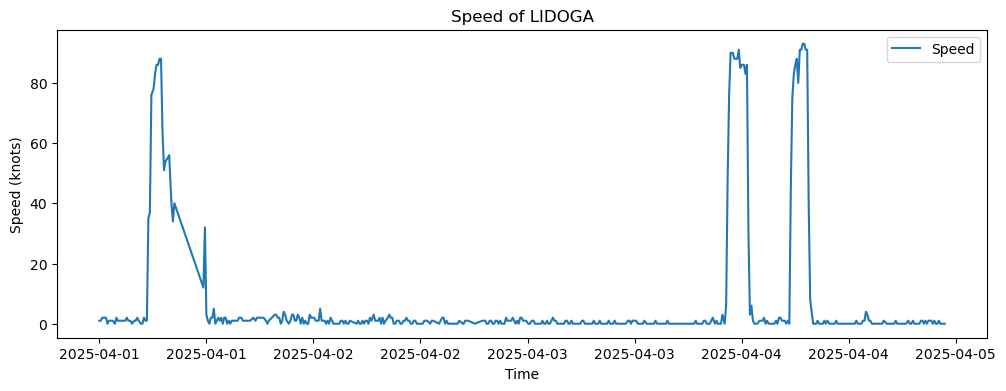

In [60]:
_, timestamps, lats, lons, speeds, courses, headings, rots, elapses, destinations, *_ = zip(*positions)

size = 500

times_dt = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=10))) for ts in timestamps[:size]]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(times_dt, speeds[:size], label="Speed")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

ax.set_xlabel("Time")
ax.set_ylabel("Speed (knots)")

ax.set_title(f"Speed of {ship["name"].decode("utf-8")}")

ax.legend()

plt.savefig(output_dir + "/speed_chart.png", bbox_inches='tight', dpi=150)
plt.savefig(output_dir + "/speed_chart.pdf", bbox_inches='tight', dpi=150)
plt.show()

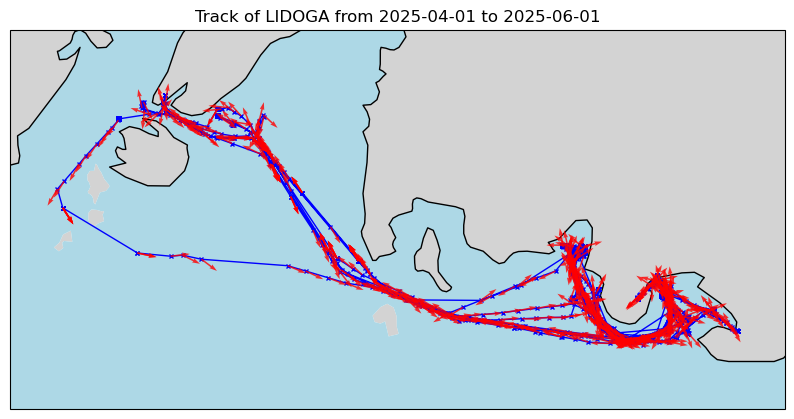

In [61]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Границы
ax.set_extent(
    [
        min(lons) - 0.1,
        max(lons) + 0.1,
        min(lats) - 0.1,
        max(lats) + 0.1,
    ],
    crs=ccrs.PlateCarree()
)

# География
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Трек
ax.plot(
    lons,
    lats,
    marker="x",
    markersize=3,
    linewidth=1,
    color="blue",
    transform=ccrs.PlateCarree(),
    zorder=3
)

# Стрелки направления
lon_q = np.asarray(lons)
lat_q = np.asarray(lats)
hdg_q = np.asarray(headings)
spd_q = np.asarray(speeds)

mask = spd_q >= 20

lon_q = lon_q[mask]
lat_q = lat_q[mask]
hdg_q = hdg_q[mask]

ang = np.deg2rad(hdg_q)
u = np.sin(ang)
v = np.cos(ang)

ax.quiver(
    lon_q, lat_q, u, v,
    transform=ccrs.PlateCarree(),
    color="red",
    angles="xy",
    scale=40,
    width=0.002,
    alpha=0.8,
    zorder=5
)

ax.set_title(f"Track of {ship["name"].decode("utf-8")} from {track_from} to {track_to}")

plt.savefig(output_dir + "/track_chart.png", bbox_inches='tight', dpi=150)
plt.savefig(output_dir + "/track_chart.pdf", bbox_inches='tight', dpi=150)
plt.show()

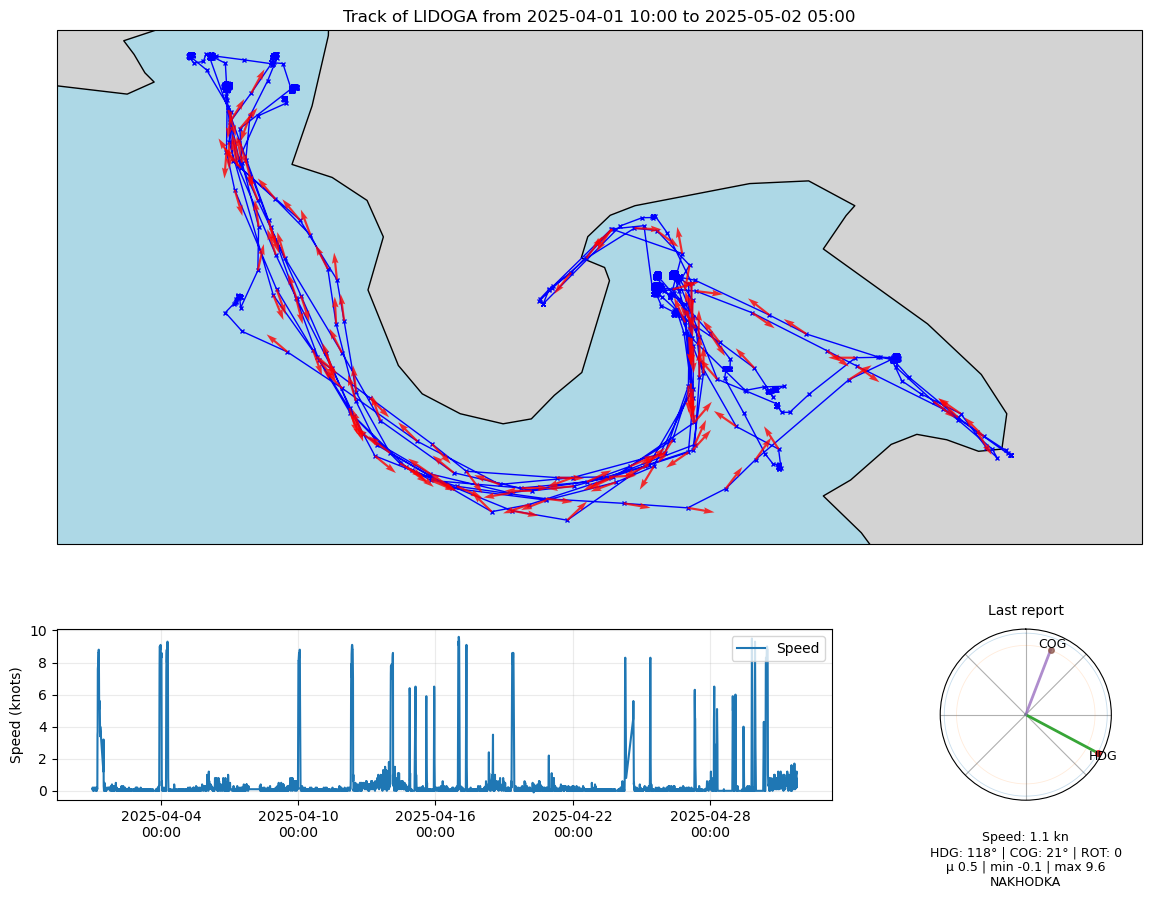

In [77]:
def plot_track_dashboard(
    positions,
    idx_from=0,
    idx_to=None,
    *,
    ship_name="Unknown vessel",
    track_from=None,
    track_to=None,
    tz_offset_hours=10,
    quiver_speed_min=20.0,        # Рисуем стрелки только когда скорость >= порога
    use_course_for_arrows=False,
    extent_source="slice",        # "slice" | "all"  (для большой анимации лучше "all")
    extent_pad_frac=0.05,         # Паддинг bbox в координатах проекции
):
    # Extract fields
    def _extract_fields(pos):
        if isinstance(pos, np.ndarray) and pos.dtype.names:
            ts  = np.asarray(pos["timestamp"])
            lat = np.asarray(pos["lat"])
            lon = np.asarray(pos["lon"])
            spd = np.asarray(pos["speed"]) / 10
            crs = np.asarray(pos["course"]) if "course" in pos.dtype.names else None
            hdg = np.asarray(pos["heading"]) if "heading" in pos.dtype.names else None
            rot = np.asarray(pos["rot"]) if "rot" in pos.dtype.names else None
            elapsed = np.asarray(pos["elapsed"])
            destination = np.asarray(pos["destination"])
            return ts, lat, lon, spd, crs, hdg, rot, elapsed, destination

        _, ts, lat, lon, spd, crs, hdg, rot, elapsed, destination, *_ = zip(*pos)
        return (
            np.asarray(ts),
            np.asarray(lat, float),
            np.asarray(lon, float),
            np.asarray(spd, float),
            np.asarray(crs, float),
            np.asarray(hdg, float),
            np.asarray(rot, float),
            np.asarray(elapsed, float),
            np.asarray(destination, str),
        )

    ts_all, lat_all, lon_all, spd_all, crs_all, hdg_all, rot_all, elapsed_all, destination_all = _extract_fields(positions)

    n = len(ts_all)
    if idx_to is None:
        idx_to = n
    idx_from = max(0, idx_from)
    idx_to = min(n, idx_to)

    ts  = ts_all[idx_from:idx_to]
    lat = lat_all[idx_from:idx_to]
    lon = lon_all[idx_from:idx_to]
    spd = spd_all[idx_from:idx_to]
    crs = crs_all[idx_from:idx_to] if crs_all is not None else None
    hdg = hdg_all[idx_from:idx_to] if hdg_all is not None else None
    rot = rot_all[idx_from:idx_to] if rot_all is not None else None
    elapsed = elapsed_all[idx_from:idx_to] if elapsed_all is not None else None
    destination = destination_all[idx_from:idx_to] if destination_all is not None else None

    if len(ts) == 0:
        raise ValueError("Empty slice: idx_from..idx_to produced no points.")

    # Filter finite points (slice)
    base_mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ts) & np.isfinite(spd)
    lon = lon[base_mask]
    lat = lat[base_mask]
    ts  = ts[base_mask]
    spd = spd[base_mask]
    if crs is not None: crs = crs[base_mask]
    if hdg is not None: hdg = hdg[base_mask]
    if rot is not None: rot = rot[base_mask]
    if elapsed is not None: elapsed = elapsed[base_mask]
    if destination is not None: destination = destination[base_mask]

    if len(ts) < 2:
        raise ValueError("Too few valid points after filtering lon/lat (need at least 2).")

    # Time axis
    tz = timezone(timedelta(hours=tz_offset_hours))
    times_dt = [datetime.fromtimestamp(int(t), tz=tz) for t in ts]

    if track_from is None:
        track_from = times_dt[0].strftime("%Y-%m-%d %H:%M")
    if track_to is None:
        track_to = times_dt[-1].strftime("%Y-%m-%d %H:%M")

    # Layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(
        2, 3, figure=fig,
        height_ratios=[3, 1],
        width_ratios=[2, 1, 1],
        hspace=0.25,
        wspace=0.25,
    )

    ax_map = fig.add_subplot(gs[0, :], projection=ccrs.Mercator())
    ax_speed = fig.add_subplot(gs[1, :2])
    ax_gauge = fig.add_subplot(gs[1, 2], projection="polar")

    # Чтобы карта занимала слот, а не квадратилась
    ax_map.set_aspect("auto")
    ax_map.set_adjustable("datalim")

    # Финальные позиции осей
    fig.canvas.draw()

    # Map extent
    def _finite_mask(lon_, lat_, ts_=None, spd_=None):
        m = np.isfinite(lon_) & np.isfinite(lat_)
        if ts_ is not None:
            m &= np.isfinite(ts_)
        if spd_ is not None:
            m &= np.isfinite(spd_)
        return m

    if extent_source == "all":
        lon_e = np.asarray(lon_all)
        lat_e = np.asarray(lat_all)
        ts_e  = np.asarray(ts_all)
        spd_e = np.asarray(spd_all)
    else:
        lon_e = np.asarray(lon)
        lat_e = np.asarray(lat)
        ts_e  = np.asarray(ts)
        spd_e = np.asarray(spd)

    mext = _finite_mask(lon_e, lat_e, ts_e, spd_e)
    lon_e = lon_e[mext]
    lat_e = lat_e[mext]

    if len(lon_e) < 2:
        raise ValueError("Too few points to compute map extent.")

    pts = ax_map.projection.transform_points(ccrs.PlateCarree(), lon_e, lat_e)
    x = pts[:, 0]
    y = pts[:, 1]

    x_min, x_max = float(np.min(x)), float(np.max(x))
    y_min, y_max = float(np.min(y)), float(np.max(y))

    xr = max(1.0, x_max - x_min)
    yr = max(1.0, y_max - y_min)

    x_pad = xr * extent_pad_frac
    y_pad = yr * extent_pad_frac

    x_min -= x_pad; x_max += x_pad
    y_min -= y_pad; y_max += y_pad

    # Расширяем bbox под аспект оси (fill)
    bbox = ax_map.get_position()     # figure coords
    fig_w, fig_h = fig.get_size_inches()
    ax_ratio = (bbox.width * fig_w) / (bbox.height * fig_h)

    xr = x_max - x_min
    yr = y_max - y_min
    data_ratio = xr / yr

    cx = (x_min + x_max) * 0.5
    cy = (y_min + y_max) * 0.5

    if data_ratio < ax_ratio:
        new_xr = ax_ratio * yr
        x_min = cx - new_xr * 0.5
        x_max = cx + new_xr * 0.5
    else:
        new_yr = xr / ax_ratio
        y_min = cy - new_yr * 0.5
        y_max = cy + new_yr * 0.5

    ax_map.set_xlim(x_min, x_max)
    ax_map.set_ylim(y_min, y_max)
    ax_map.set_anchor("C")

    # Map layers
    ax_map.add_feature(cfeature.OCEAN, facecolor="lightblue", zorder=0)
    ax_map.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
    ax_map.coastlines(resolution="10m", zorder=1)
    ax_map.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=1)

    # Track
    ax_map.plot(
        lon, lat,
        marker="x", markersize=3,
        linewidth=1, color="blue",
        transform=ccrs.PlateCarree(),
        zorder=3,
    )

    # Quiver arrows
    dir_deg = (crs if (use_course_for_arrows and crs is not None) else hdg)
    if dir_deg is not None:
        dir_deg = np.asarray(dir_deg)

        qmask = (
            (spd >= quiver_speed_min)
            & np.isfinite(dir_deg)
            & (dir_deg >= 0) & (dir_deg <= 360)
            & (dir_deg != 511) & (dir_deg != -1)
        )

        lon_q = lon[qmask]
        lat_q = lat[qmask]
        dir_q = dir_deg[qmask]

        ang = np.deg2rad(dir_q)
        u = np.sin(ang)
        v = np.cos(ang)

        ax_map.quiver(
            lon_q, lat_q, u, v,
            transform=ccrs.PlateCarree(),
            color="red",
            angles="xy",
            scale=40,
            width=0.002,
            alpha=0.8,
            zorder=5,
        )

    ax_map.set_title(f"Track of {ship_name} from {track_from} to {track_to}")

    # Speed plot
    ax_speed.plot(times_dt, spd, label="Speed")
    ax_speed.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
    ax_speed.xaxis.set_major_locator(MaxNLocator(6))
    ax_speed.set_ylabel("Speed (knots)")
    ax_speed.grid(True, alpha=0.25)
    ax_speed.legend(loc="upper right")

    # Gauge (polar) + stats
    ax_gauge.set_theta_zero_location("N")
    ax_gauge.set_theta_direction(-1)
    ax_gauge.set_rticks([])
    ax_gauge.set_xticklabels([])
    ax_gauge.set_yticklabels([])

    th = np.linspace(0, 2*np.pi, 200)
    ax_gauge.plot(th, np.ones_like(th) * 1.00, linewidth=0.6, alpha=0.25)
    ax_gauge.plot(th, np.ones_like(th) * 0.85, linewidth=0.6, alpha=0.15)

    spd_last = float(spd[-1])
    crs_last = float(crs[-1]) if crs is not None else np.nan
    hdg_last = float(hdg[-1]) if hdg is not None else np.nan
    rot_last = float(rot[-1]) if rot is not None else np.nan
    elapsed_last = float(elapsed[-1]) if elapsed is not None else np.nan
    destination_last = str(destination[-1].decode("utf-8")) if destination is not None else "-"

    def draw_compass_line(deg, r, label, alpha=0.9):
        if not np.isfinite(deg) or deg in (-1, 511) or deg < 0 or deg > 360:
            return
        theta = np.deg2rad(deg)
        ax_gauge.plot([theta, theta], [0.0, r], linewidth=2.0, alpha=alpha)
        ax_gauge.plot([theta], [r], marker="o", markersize=4, alpha=alpha)
        ax_gauge.text(theta, r * 1.08, label, ha="center", va="center", fontsize=9)

    draw_compass_line(hdg_last, 1.00, "HDG", alpha=0.95)
    draw_compass_line(crs_last, 0.85, "COG", alpha=0.75)

    ax_gauge.set_title("Last report", fontsize=10, pad=10)

    # Текст под компасом
    spd_mean = float(np.mean(spd))
    spd_min = float(np.min(spd))
    spd_max = float(np.max(spd))

    hdg_txt = "n/a" if not np.isfinite(hdg_last) else f"{hdg_last:.0f}°"
    cog_txt = "n/a" if not np.isfinite(crs_last) else f"{crs_last:.0f}°"
    rot_txt = "n/a" if not np.isfinite(rot_last) else f"{rot_last:.0f}"

    stats_text = (
        f"Speed: {spd_last:.1f} kn\n"
        f"HDG: {hdg_txt} | COG: {cog_txt} | ROT: {rot_txt}\n"
        f"μ {spd_mean:.1f} | min {spd_min:.1f} | max {spd_max:.1f}\n"
        f"{destination_last}"
    )

    ax_gauge.text(
        0.5, -0.18,
        stats_text,
        transform=ax_gauge.transAxes,
        ha="center",
        va="top",
        fontsize=9,
        clip_on=False,
    )

    return fig, (ax_map, ax_speed, ax_gauge)

fig, axes = plot_track_dashboard(
    positions,
    idx_from=0,
    idx_to=len(positions) // 2,
    ship_name=ship["name"].decode("utf-8"),
    tz_offset_hours=10,
    quiver_speed_min=5,
    use_course_for_arrows=False,
    extent_source="slice",
)

In [ ]:
window_size = 100
frame_count = len(positions)

os.makedirs(output_dir + "/frames", exist_ok=True)

for i in tqdm(range(2, frame_count + window_size - 2)):
    # Выделаем позиции для кадра
    if i < window_size:
        # Начальные кадры
        idx_from = 0
        idx_to = i + 1
    else:
        # Скользящее окно
        idx_from = i - window_size + 1
        idx_to = i + 1
    
    fig, axes = plot_track_dashboard(
        positions,
        idx_from=idx_from,
        idx_to=idx_to,
        ship_name=ship["name"].decode("utf-8"),
        tz_offset_hours=10,
        quiver_speed_min=5,
        use_course_for_arrows=False,
        extent_source="slice",
    )
    
    frame_path = os.path.join(output_dir + "/frames", f"frame_{i-2:04d}.png")
    plt.savefig(frame_path, bbox_inches='tight', dpi=150)
    plt.close()

In [ ]:
%cd output/shiptrace_lidoga_frames_2025-04-01_to_2025-05-01

!ffmpeg -y -framerate 60 -i frame_%04d.png -c:v libx264 -crf 27 shiptrace_lidoga.mp4